In [4]:
import pandas as pd

# CSV dosyasını oku
df = pd.read_csv('insurance.csv')

# Veri çerçevesini görüntüle
print(df.columns)


Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error


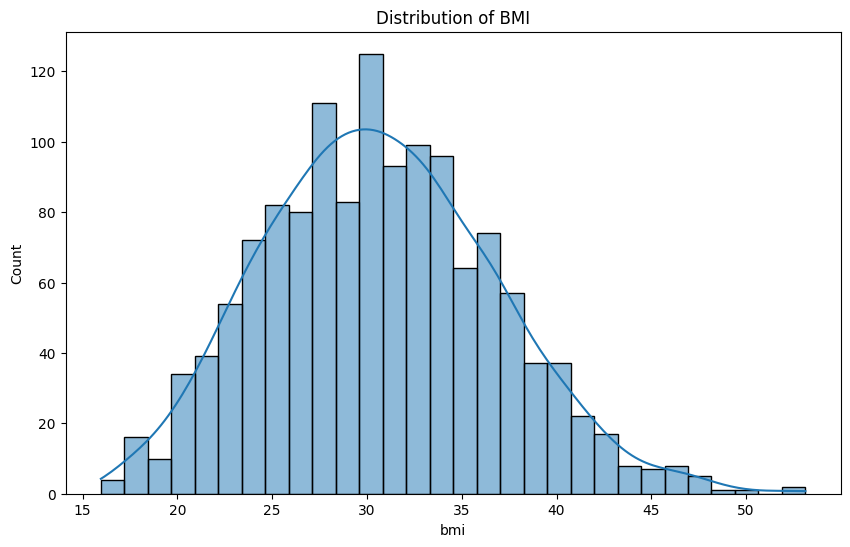

In [10]:
# Veri setini yükle
df = pd.read_csv('insurance.csv')

# Bmi Dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(df['bmi'], bins=30, kde=True)
plt.title('Distribution of BMI')
plt.show()
# Diğer analizler aynı şekilde devam eder...


In [11]:
# Kategorik değişkenleri sayısal değerlere dönüştürme
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])
df['smoker'] = label_encoder.fit_transform(df['smoker'])
df['region'] = label_encoder.fit_transform(df['region'])

# One-Hot Encoding
df = pd.get_dummies(df, columns=['region'], drop_first=True)

# Verileri X ve y olarak ayırma
X = df.drop('charges', axis=1)
y = df['charges']

# Verileri eğitim ve test setlerine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verileri ölçeklendirme
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [12]:
# Farklı regresyon modellerini seçme
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Support Vector Regressor': SVR()
}

# Modelleri eğitme ve çapraz doğrulama ile performansı değerlendirme
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    results[model_name] = rmse_scores.mean()

# Modelleri performansa göre sıralama
sorted_results = sorted(results.items(), key=lambda x: x[1])
for model_name, rmse_score in sorted_results:
    print(f'{model_name}: RMSE = {rmse_score:.2f}')


Random Forest Regressor: RMSE = 4983.11
Linear Regression: RMSE = 6147.09
Support Vector Regressor: RMSE = 12566.80


In [13]:
# En iyi sonuç veren modeli seçme
best_model_name = sorted_results[0][0]
best_model = models[best_model_name]

# Grid Search ile hiperparametre optimizasyonu
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve sonuçları yazdırma
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END ma

[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=1

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total

[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total tim

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total tim

[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.6s
Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: 4736.502705471422


In [15]:
# En iyi modeli seçme
best_model = grid_search.best_estimator_

# Test verileri üzerinde tahmin yapma
y_pred = best_model.predict(X_test)

# Hata metriklerini hesaplama
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Sonuçları yazdırma
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


Mean Squared Error (MSE): 19356160.92
Mean Absolute Error (MAE): 2491.13
Root Mean Squared Error (RMSE): 4399.56


In [16]:
# Model seçimi ve eğitimi
best_model = RandomForestRegressor()  # Örnek olarak Random Forest Regressor seçildi
best_model.fit(X_train, y_train)



RandomForestRegressor()

In [17]:
# Grid Search ile hiperparametre optimizasyonu
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# En iyi model ve sonuçları
best_model = grid_search.best_estimator_
best_rmse = np.sqrt(-grid_search.best_score_)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", best_rmse)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END ma

[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=1

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total

[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total tim

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total tim

[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.7s
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best RMSE: 4737.075776717189
